In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.subplots as tls
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from timeit import default_timer as timer
import matplotlib
#%matplotlib inline

# Import the dimensionality reduction methods
from sklearn.decomposition import PCA
from sklearn import manifold, datasets

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

train = pd.read_csv('C:\\Users\\Saite\\Desktop\\Bobby\\train1.csv')
# save the labels to a Pandas series target
target = train['label']
# Drop the label feature
train = train.drop("label",axis=1)

# Standardize the data
from sklearn.preprocessing import StandardScaler
X = train.values
X_std = StandardScaler().fit_transform(X)

# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the eigenvalue, eigenvector pair from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

trace1 = go.Scatter(
    x=list(range(784)),
    y= cum_var_exp,
    mode='lines+markers',
    name="'Cumulative Explained Variance'",
#     hoverinfo= cum_var_exp,
    line=dict(
        shape='spline',
        color = 'goldenrod'
    )
)
trace2 = go.Scatter(
    x=list(range(784)),
    y= var_exp,
    mode='lines+markers',
    name="'Individual Explained Variance'",
#     hoverinfo= var_exp,
    line=dict(
        shape='linear',
        color = 'black'
    )
)
fig = tls.make_subplots(insets=[{'cell': (1,1), 'l': 0.7, 'b': 0.5}],
                          print_grid=True)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2,1,1)
fig.layout.title = 'Explained Variance plots - Full and Zoomed-in'
fig.layout.xaxis = dict(range=[0, 80], title = 'Feature columns')
fig.layout.yaxis = dict(range=[0, 60], title = 'Explained Variance')

This is the format of your plot grid:
[ (1,1) x,y ]

With insets:
[ x2,y2 ] over [ (1,1) x,y ]



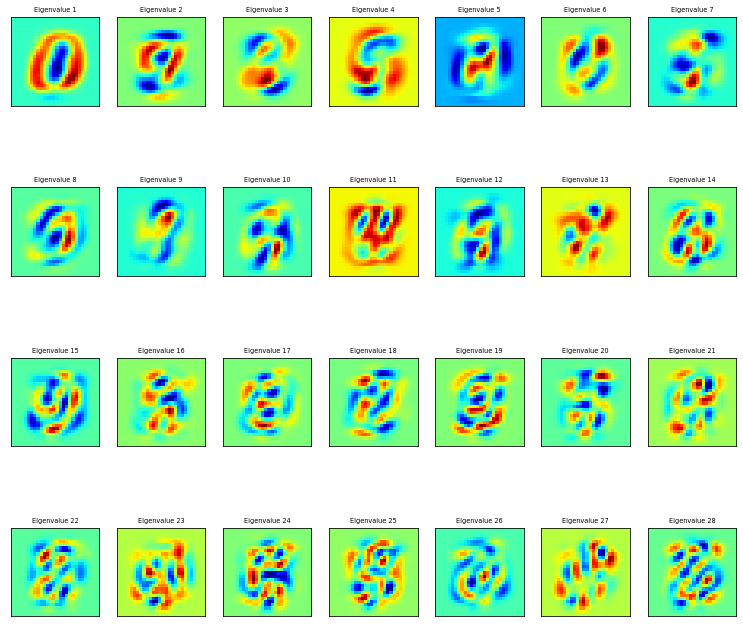

In [3]:
# Invoke SKlearn's PCA method
n_components = 30
pca = PCA(n_components=n_components).fit(train.values)

eigenvalues = pca.components_.reshape(n_components, 28, 28)

# Extracting the PCA components ( eignevalues )
#eigenvalues = pca.components_.reshape(n_components, 28, 28)
eigenvalues = pca.components_

n_row = 4
n_col = 7

# Plot the first 8 eignenvalues
plt.figure(figsize=(13,12))
for i in list(range(n_row * n_col)):
    offset =0
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(eigenvalues[i].reshape(28,28), cmap='jet')
    title_text = 'Eigenvalue ' + str(i + 1)
    plt.title(title_text, size=6.5)
    plt.xticks(())
    plt.yticks(())
plt.show()

In [5]:
from timeit import default_timer as timer
# Call the PCA method with 2 components. 
pca = PCA(n_components=2)
start = timer()
X_2d = pca.fit_transform(X_std)
# For cluster coloring in our Plotly plots, remember to also restrict the target values 
Target = target

In [6]:
#2D plot
tracePCA = go.Scatter(
    x = X_2d[:,0],
    y = X_2d[:,1],
    name = str(Target),
    
    mode = 'markers',
    text = Target,
    showlegend = False,
    marker = dict(
        size = 8,
        color = Target,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        
        opacity = 0.8
    )
)
data = [tracePCA]

layout = go.Layout(title = '2D PCA (Principal Component Analysis)',
              hovermode= 'closest',
              xaxis = dict(zeroline = False),
              yaxis = dict(zeroline = False),
              showlegend= False,

             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='2D-scatter')
print("with CPU:", timer()-start)

with CPU: 3.3836761000000024


In [19]:
# KMeans clustering 
kmeans = KMeans(n_clusters=10)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(X_2d)

trace_Kmeans = go.Scatter(x=X_2d[:, 0], y= X_2d[:, 1], mode="markers",
                    showlegend=False,
                    marker=dict(
                            size=8,
                            color = X_clustered,
                            colorscale = 'Portland',
                            showscale=False, 
                            line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        )
                   ))

layout = go.Layout(
    title= 'KMeans Clustering',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Principal Component',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Principal Component',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= True
)

data = [trace_Kmeans]
fig1 = dict(data=data, layout= layout)
py.iplot(fig1, filename="KM")
print('Clustering Score',silhouette_score(X_2d,X_clustered))

Clustering Score 0.3381494881475786


In [20]:
X_clustered = SpectralClustering(n_clusters=10, affinity='nearest_neighbors',n_neighbors=12,#nearest_neighbors
                          assign_labels='kmeans',random_state=0).fit_predict(X_2d)

trace_sc = go.Scatter(x=X_2d[:, 0], y= X_2d[:, 1], mode="markers",
                    showlegend=False,
                    marker=dict(
                            size=8,
                            color = X_clustered,
                            colorscale = 'Portland',
                            showscale=False, 
                            line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        )
                   ))

layout = go.Layout(
    title= 'Spectral Clustering',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Principal Component',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Principal Component',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= True
)

data = [trace_sc]
fig1 = dict(data=data, layout= layout)
py.iplot(fig1, filename="SC")
print('Clustering Score',silhouette_score(X_2d,X_clustered))

Clustering Score 0.289925460677464


In [22]:
# Invoking the 3D t-SNE method
tsne = PCA(n_components=3)
start = timer()
X_3d = tsne.fit_transform(X_std)
Target = target#remeber to pass all the labels

traceTSNE = go.Scatter3d(
    x = X_3d[:,0],
    y = X_3d[:,1],
    z = X_3d[:,2],
    mode = 'markers',
    text = Target,
    showlegend = True,
    marker = dict(
        size = 8,
        color = Target,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [traceTSNE]

layout = go.Layout(title = '3D PCA (Principal Component Analysis)',
              hovermode= 'closest',
              xaxis = dict(zeroline = False),
              yaxis = dict(zeroline = False),
              showlegend= False,

             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='3D-scatter')
print("with CPU:", timer()-start)

with CPU: 0.5467102999998588


In [23]:
# KMeans clustering 
kmeans = KMeans(n_clusters=10)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(X_3d)

trace_Kmeans = go.Scatter3d(x=X_3d[:, 0], y= X_3d[:, 1],z=X_3d[:, 2], mode="markers",
                    showlegend=False,
                    marker=dict(
                            size=8,
                            color = X_clustered,
                            colorscale = 'Portland',
                            showscale=False, 
                            line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        )
                   ))

layout = go.Layout(
    title= 'KMeans Clustering',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Principal Component',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Principal Component',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= True
)

data = [trace_Kmeans]
fig1 = dict(data=data, layout= layout)
py.iplot(fig1, filename="KM")
print('Clustering Score',silhouette_score(X_3d,X_clustered))

Clustering Score 0.2842139485021587


In [24]:
X_clustered = SpectralClustering(n_clusters=10, affinity='nearest_neighbors',n_neighbors=12,
                          assign_labels='kmeans',random_state=0).fit_predict(X_3d)

trace_sc = go.Scatter3d(x=X_3d[:, 0], y= X_3d[:, 1],z=X_3d[:, 2], mode="markers",
                    showlegend=False,
                    marker=dict(
                            size=8,
                            color = X_clustered,
                            colorscale = 'Portland',
                            showscale=False, 
                            line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        )
                   ))

layout = go.Layout(
    title= 'Spectral Clustering',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Principal Component',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Principal Component',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= True
)

data = [trace_sc]
fig1 = dict(data=data, layout= layout)
py.iplot(fig1, filename="SC")
print('Clustering Score',silhouette_score(X_3d,X_clustered))


Clustering Score 0.1928760675528391
